# Azure ML experiments
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

## 0. Settings

In [30]:
import datetime
today = datetime.datetime.now()
print("Today is", today)

Today is 2021-01-08 12:09:53.600813


In [31]:
import scipy, matplotlib, pandas, sklearn
import numpy as np
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [32]:
import sys
print("You are using Python", sys.version)

You are using Python 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [33]:
print("Releases:")
print('- scipy = {}'.format(scipy.__version__))
print('- numpy = {}'.format(np.__version__))
print('- matplotlib = {}'.format(matplotlib.__version__))
print('- pandas = {}'.format(pandas.__version__))
print('- sklearn = {}'.format(sklearn.__version__))
print("- Azure ML =",azureml.core.VERSION)

Releases:
- scipy = 1.5.2
- numpy = 1.18.5
- matplotlib = 3.2.1
- pandas = 0.25.3
- sklearn = 0.22.2.post1
- Azure ML = 1.19.0


> Azure ML Release notes: https://docs.microsoft.com/en-us/azure/machine-learning/azure-machine-learning-release-notes

## Let's connect to the Azure ML workspace

In [34]:
from azureml.core import Workspace

ws = Workspace.from_config()
print('Azure ML Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Azure ML Workspace name: AMLworkshop
Azure region: westeurope
Resource group: AMLworkshop-rg


## 1. Data

In [35]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

In [36]:
# scikit-learn version
import sklearn
print("You are using scikit-learn", sklearn.__version__)

You are using scikit-learn 0.22.2.post1


#### Data : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [37]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [38]:
# Test population in %
testsizepct=0.30

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [40]:
nobstrain=len(data['train']['X'])
nobstest=len(data['test']['X'])
nobstotal=nobstrain+nobstest
pcttrain=round(nobstrain/nobstotal*100,2)
pcttest=round(nobstest/nobstotal*100,2)
print ("Training dataset =", nobstrain, 'observations -', pcttrain, '%')
print ("Test dataset =", nobstest, 'observations -', pcttest,'%')

Training dataset = 309 observations - 69.91 %
Test dataset = 133 observations - 30.09 %


## 2. Let's build a model to predict Diabetes level

We will use a **Ridge** regression.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>




### Creation of an Azure ML experimentation

In [41]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="Experimentation-Diabetes")

In [42]:
def regridge(k):
    
    # 1. Starting
    run = experiment.start_logging(snapshot_directory=None)
    
    print('k =', k)
    print()    
       
    # 2. Logging
    run.log('k', k) 
    run.log('Test Size', testsizepct)
    run.log('Nobs Training', nobstrain)
    run.log('Nobs Test', nobstest)
    
    print('Test Size =', testsizepct)
    print('Numbers of obs for the Training dataset =', nobstrain)
    print('Number of obs for the Testing dataset =', nobstest)    
    print()
    
    # 3. ML model
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Logging ML metrics
    from sklearn.metrics import r2_score
    import math
    
    mse = round(mean_squared_error(data['test']['y'], preds), 4)
    rmse = round(math.sqrt(mse), 4)
    R2 = round(r2_score(data['test']['y'], preds), 4)
    
    print('- RMSE =', rmse)
    print('- MSE =', mse)
    print('- R2 =', R2)
    
    run.log("rmse", rmse)
    run.log('mse', mse)
    run.log('R2', R2)

    # 5. Saving the model
    
    model_name = "RegRidgeModele-k-" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    joblib.dump(value=regression_model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    
    # 6. Tags
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", "1.1.18")
    run.tag("Team", "DataScience France")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 7. Graph generation
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("outputs/RegRidgeGraphique-k-"+str(k)+".png")
    plt.title('Ridge', fontsize=10)
    
    run.log_image(name='My Graph', plot=plt) # Logging the graph into the experiment
    
    # 6. End
    run.complete()

### Let's call the Python function with different k values

k = 0.1

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.2271
- MSE = 3050.0324
- R2 = 0.4021


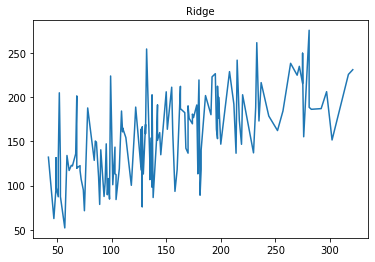

In [43]:
regridge(0.1)

k = 0.2

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.0152
- MSE = 3026.6677
- R2 = 0.4067


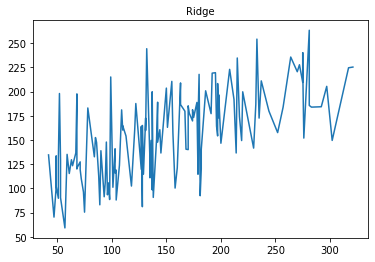

In [44]:
regridge(0.2)

k = 0.3

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.0521
- MSE = 3030.7343
- R2 = 0.4059


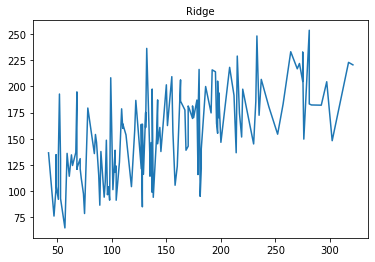

In [45]:
regridge(0.3)

## Let's save the best model into the model repository. All models are versioned.

Best model is for k=0.2

In [46]:
mymodel='RegRidgeModele-k-0.2.pkl'
k=0.2

RMSE = 55.0152
MSE = 3026.6677
R2 = 0.4067

In [47]:
from azureml.core.model import Model

model = Model.register(model_path="outputs/"+mymodel, 
                       model_name="diabeteprediction", 
                       model_framework=Model.Framework.SCIKITLEARN, 
                       model_framework_version='0.22.2',            
                       tags={'area': 'Diabetes', 
                             'type': 'Ridge', 
                             'k':k, 
                             'MSE' : MSE, 
                             'R2' : R2,
                             'RMSE' : RMSE,
                             'Framework' : 'Azure ML'},
                       description="My Ridge regression model for Diabetes prediction",
                       workspace=ws) 

Registering model diabeteprediction


In [48]:
model.created_time

datetime.datetime(2021, 1, 8, 12, 10, 40, 346508, tzinfo=<isodate.tzinfo.Utc object at 0x7f223ef84b70>)

In [49]:
model.id

'diabeteprediction:4'

In [50]:
model.tags

{'area': 'Diabetes',
 'type': 'Ridge',
 'k': '0.2',
 'MSE': '3026.6677',
 'R2': '0.4067',
 'RMSE': '55.0152',
 'Framework': 'Azure ML'}

In [51]:
experiment

Name,Workspace,Report Page,Docs Page
Experimentation-Diabetes,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation
